In [1]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from utils.data_utils import *
from model.encoder import Encoder
from model.generator import Generator
from model.discriminator import Discrimator

import matplotlib.pyplot as plt

In [2]:
def weight_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv3d') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# Args

In [3]:
choose_cuda = True
data_dir = '/home/ewok261/Documents/psychic-gan/data/in_4_out_1_ol_0'
frm_in = 4
frm_out = 1
mini_batch = 4
n_epochs = 200

In [4]:
if choose_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Load data

In [5]:
all_data = KITTIData(frm_in, frm_out, 0, data_dir)
[train_data,val_data] = data.random_split(all_data, [600, 187])
[train_data, _] = data.random_split(train_data, [10, 590]) # take a small subset of training data (for overfitting)
[val_data, _] = data.random_split(val_data, [30, 157])
train_loader = data.DataLoader(train_data, batch_size = mini_batch, shuffle=True, num_workers=1)
val_loader = data.DataLoader(val_data, batch_size = 1, shuffle = False, num_workers = 1)
print('Train size: {0}'.format(len(train_data)))
print('Val size: {0}'.format(len(val_data)))

Train size: 10
Val size: 30


# Define the network and loss

In [6]:
loss_fun = nn.MSELoss()

encoder = Encoder(frame_dim=64, init_temp=3, hidden_dim=128, out_filters=256,
                  attention_at=32, norm=nn.utils.weight_norm, residual=True)
encoder = encoder.to(device)
encoder_optim = optim.Adam(encoder.parameters(), betas=(0.9, 0.999))

generator = Generator(frame_dim=64, temporal_target=1, hidden_dim=128,
                      init_filters=256, attention_at=32, norm=nn.utils.weight_norm)
generator = generator.to(device)
generator_optim = optim.Adam(generator.parameters(), betas=(0.9, 0.999))

encoder.apply(weight_init)
generator.apply(weight_init)

#summary(encoder, input_size=(3, frm_in, 64, 64))
#summary(generator, input_size=(128,))

Generator(
  (linear): Linear(in_features=128, out_features=4096, bias=True)
  (up_stack): ModuleList(
    (0): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (upsample): Upsample(size=(1, 8, 8), mode=nearest)
        )
      )
    )
    (1): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (upsample): Upsample(size=(1, 16, 16), mode=nearest)
        )
      )
    )
    (2): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

In [7]:
print(encoder)
print(generator)

Encoder(
  (linear): Linear(in_features=8192, out_features=128, bias=True)
  (down_stack): ModuleList(
    (0): ResidualNormConv3D(
      (layer): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        )
      )
      (layer_1): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(3, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        )
      )
    )
    (1): ResidualNormConv3D(
      (layer): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
        )
      )
      (layer_1): NormConvND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(32, 64, kernel_size=(1, 1, 1), s

# Training loop

In [8]:
train_hist_real = []
train_hist_gen = []
val_hist = []
for epoch in range(n_epochs):
        running_loss_gen = 0.0
        running_loss_real = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs and move them to device
            in_frames, out_frames = data
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # zero the parameter gradients
            encoder.zero_grad()
            generator.zero_grad()
            
            # GENERATOR/ENCODER TRAINING
            hidden, encoder_attn = encoder(in_frames)
            generated, generator_attn = generator(hidden)
            
            loss_gen = loss_fun(generated, out_frames)
            
            loss_gen.backward()
            encoder_optim.step()
            generator_optim.step()

            # print statistics
            running_loss_gen += loss_gen.item() / 3
            if i % 3 == 2:
                print('[Epoch {0} - Step {1}] R-loss: {2} G-loss: {3}'.format(epoch, i, running_loss_real, running_loss_gen))
                train_hist_real.append(running_loss_real)
                train_hist_gen.append(running_loss_gen)
                running_loss_real = 0
                running_loss_gen = 0

        val_loss = 0.0
        for in_frames, out_frames in val_loader:
            # get the validation inputs and outputs
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # forward
            with torch.no_grad():
                hidden, encoder_attn = encoder(in_frames)
                generated, generator_attn = generator(hidden)
            
            val_loss += loss_fun(generated, out_frames).item() / len(val_loader)
            #val_loss += loss_fun(generated, out_frames).item() / len(val_loader)

        print('[Epoch {0}] Val-Loss: {1}'.format(epoch, val_loss))
        val_hist.append(val_loss)

[Epoch 0 - Step 2] R-loss: 0.0 G-loss: 1.2134250154097874
[Epoch 0] Val-Loss: 0.11200864327450591
[Epoch 1 - Step 2] R-loss: 0.0 G-loss: 0.1530483514070511
[Epoch 1] Val-Loss: 0.13757256635775167
[Epoch 2 - Step 2] R-loss: 0.0 G-loss: 0.15244657794634503
[Epoch 2] Val-Loss: 0.1261298694337408
[Epoch 3 - Step 2] R-loss: 0.0 G-loss: 0.1393007387717565
[Epoch 3] Val-Loss: 0.11457131169736381
[Epoch 4 - Step 2] R-loss: 0.0 G-loss: 0.12134650349617004
[Epoch 4] Val-Loss: 0.11400490899880728
[Epoch 5 - Step 2] R-loss: 0.0 G-loss: 0.1143088216582934
[Epoch 5] Val-Loss: 0.10360737293958663
[Epoch 6 - Step 2] R-loss: 0.0 G-loss: 0.10127419481674829
[Epoch 6] Val-Loss: 0.09519774739940962
[Epoch 7 - Step 2] R-loss: 0.0 G-loss: 0.09607539077599844
[Epoch 7] Val-Loss: 0.09733460669716198
[Epoch 8 - Step 2] R-loss: 0.0 G-loss: 0.09390180061260858
[Epoch 8] Val-Loss: 0.09622619549433391
[Epoch 9 - Step 2] R-loss: 0.0 G-loss: 0.09210163354873657
[Epoch 9] Val-Loss: 0.08983631134033201
[Epoch 10 - Ste

[Epoch 81] Val-Loss: 0.09288849110404651
[Epoch 82 - Step 2] R-loss: 0.0 G-loss: 0.02335963336129983
[Epoch 82] Val-Loss: 0.08854387265940508
[Epoch 83 - Step 2] R-loss: 0.0 G-loss: 0.025630357364813488
[Epoch 83] Val-Loss: 0.09287265290816626
[Epoch 84 - Step 2] R-loss: 0.0 G-loss: 0.023156120752294857
[Epoch 84] Val-Loss: 0.09363002118964991
[Epoch 85 - Step 2] R-loss: 0.0 G-loss: 0.02313721925020218
[Epoch 85] Val-Loss: 0.09661564975976943
[Epoch 86 - Step 2] R-loss: 0.0 G-loss: 0.02205936424434185
[Epoch 86] Val-Loss: 0.09290691862503687
[Epoch 87 - Step 2] R-loss: 0.0 G-loss: 0.02135626475016276
[Epoch 87] Val-Loss: 0.09396383898953595
[Epoch 88 - Step 2] R-loss: 0.0 G-loss: 0.019927486466864746
[Epoch 88] Val-Loss: 0.09349732212722303
[Epoch 89 - Step 2] R-loss: 0.0 G-loss: 0.019419449691971142
[Epoch 89] Val-Loss: 0.09355670685569445
[Epoch 90 - Step 2] R-loss: 0.0 G-loss: 0.01948244869709015
[Epoch 90] Val-Loss: 0.09462765194475652
[Epoch 91 - Step 2] R-loss: 0.0 G-loss: 0.0195

[Epoch 161] Val-Loss: 0.0976205863058567
[Epoch 162 - Step 2] R-loss: 0.0 G-loss: 0.012048429809510708
[Epoch 162] Val-Loss: 0.09751874270538488
[Epoch 163 - Step 2] R-loss: 0.0 G-loss: 0.011448952679832775
[Epoch 163] Val-Loss: 0.09771939404308798
[Epoch 164 - Step 2] R-loss: 0.0 G-loss: 0.011563699692487715
[Epoch 164] Val-Loss: 0.09703625117739044
[Epoch 165 - Step 2] R-loss: 0.0 G-loss: 0.011831539683043957
[Epoch 165] Val-Loss: 0.09949869861205418
[Epoch 166 - Step 2] R-loss: 0.0 G-loss: 0.01115961978211999
[Epoch 166] Val-Loss: 0.09750845233599344
[Epoch 167 - Step 2] R-loss: 0.0 G-loss: 0.011992616889377434
[Epoch 167] Val-Loss: 0.09758218104640642
[Epoch 168 - Step 2] R-loss: 0.0 G-loss: 0.011979351130624613
[Epoch 168] Val-Loss: 0.09869153623779614
[Epoch 169 - Step 2] R-loss: 0.0 G-loss: 0.011904540161291758
[Epoch 169] Val-Loss: 0.09753308470050495
[Epoch 170 - Step 2] R-loss: 0.0 G-loss: 0.011306161992251875
[Epoch 170] Val-Loss: 0.09892545516292253
[Epoch 171 - Step 2] R-l

# Results visualization

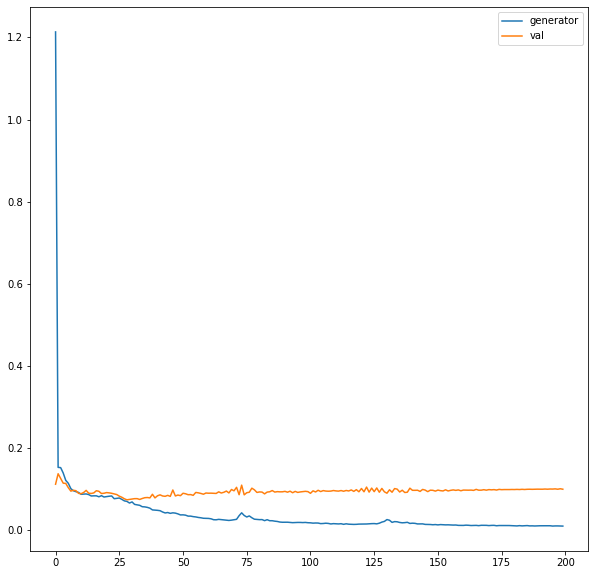

In [9]:
plt.figure(figsize=(10, 10))
plt.plot(train_hist_gen)
plt.plot(val_hist)
plt.legend(['generator', 'val'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 4, 64, 64])
torch.Size([1, 3, 1, 64, 64])


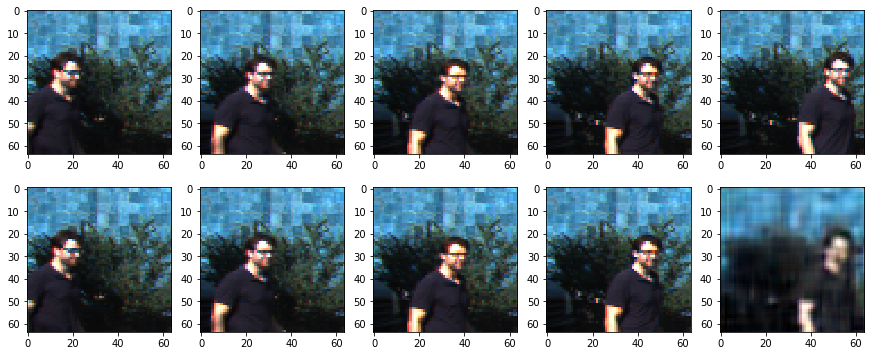

In [31]:
insamp, outsamp = train_data[0]
insamp = insamp.unsqueeze(0)
outsamp = outsamp.unsqueeze(0)
print(insamp.shape)
print(outsamp.shape)
insamp, outsamp = insamp.to(device), outsamp.to(device)

with torch.no_grad():
    hidval, encval_attn = encoder(insamp)
    genval, genval_attn = generator(hidval)

insamp = insamp.cpu().squeeze().permute(1,2,3,0).numpy()
genval = genval.cpu().squeeze().permute(1,2,0).detach().numpy()
outsamp = outsamp.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(15, 6))
# img
for idx in range(frm_in):
    plt.subplot(2, frm_in+frm_out, idx+1)
    plt.imshow(insamp[idx])
for idx in range(frm_out):
    plt.subplot(2, frm_in+frm_out, frm_in+idx+1)
    plt.imshow(outsamp)

# target
for idx in range(frm_in):
    plt.subplot(2, frm_in+frm_out, frm_in+frm_out+idx+1)
    plt.imshow(insamp[idx])
for idx in range(frm_out):
    plt.subplot(2, frm_in+frm_out, frm_out+2*frm_in+idx+1)
    plt.imshow(genval)

In [32]:
encval_attn = encval_attn.cpu().squeeze().detach().numpy()
genval_attn = genval_attn.cpu().squeeze().detach().numpy()
print(encval_attn.shape)
print(genval_attn.shape)

(2, 32, 32, 2, 32, 32)
(32, 32, 32, 32)


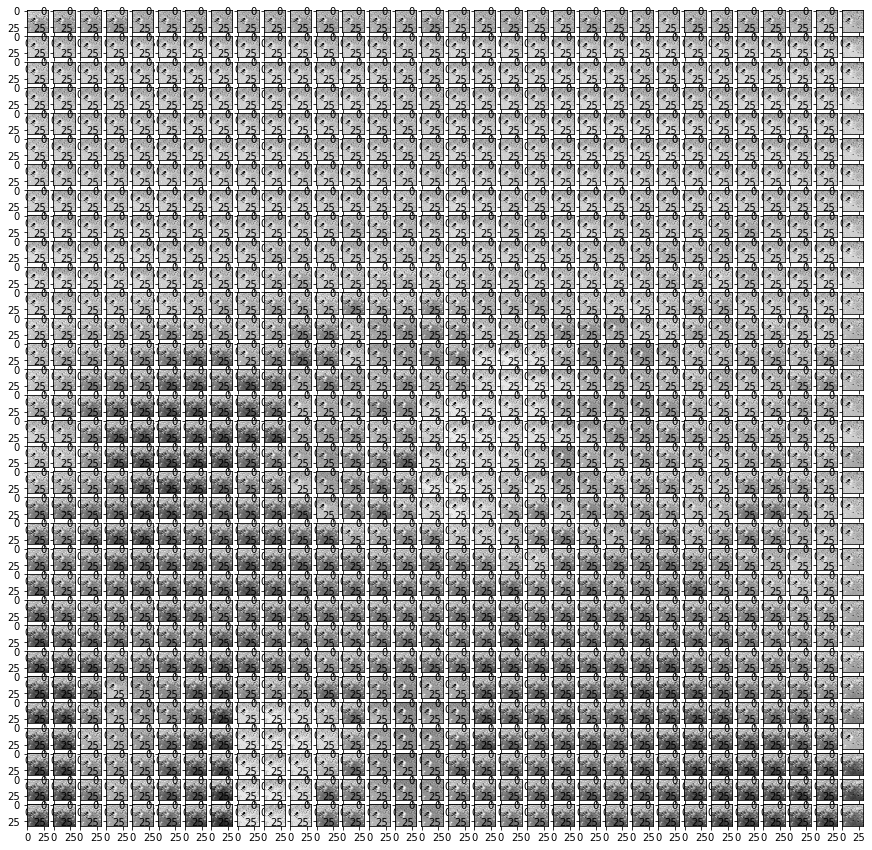

In [33]:
plt.figure(figsize=(15, 15))
act_tens = encval_attn
for idx in range(act_tens.shape[1]):
    for idy in range(act_tens.shape[2]):
        plt.subplot(act_tens.shape[1], act_tens.shape[2], idy + idx*act_tens.shape[1] + 1)
        plt.imshow(act_tens[1,idx,idy,0,:,:], cmap = 'gray')
plt.show()

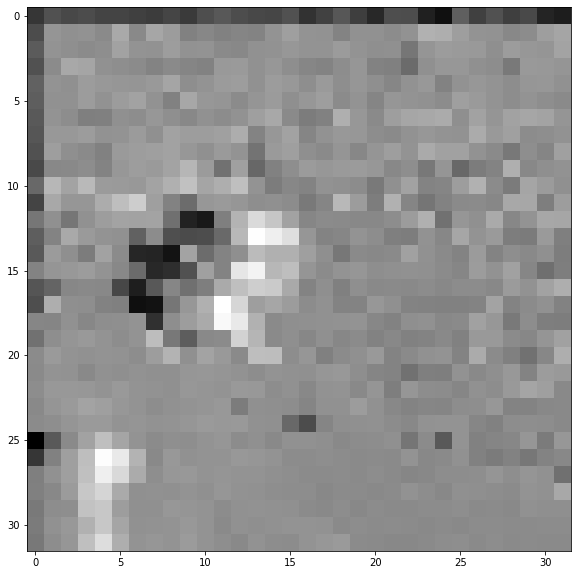

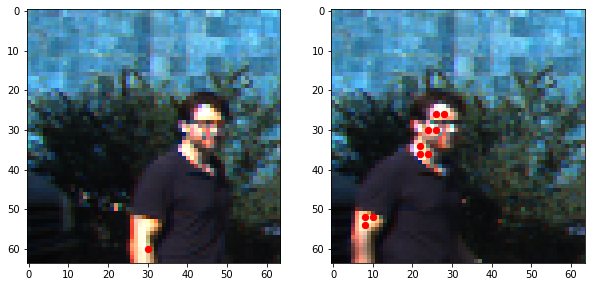

In [37]:
orig_x = 60
orig_y = 30
plt.figure(figsize=(10, 10))
plt.imshow(encval_attn[1,orig_x // 2, orig_y // 2, 0, :, :], cmap = 'gray')
plt.show()

top_attn = encval_attn[1, orig_x // 2, orig_y // 2, 0, :, :]
idx = np.argsort(top_attn,axis = None)[-10:]
midx = np.unravel_index(idx, top_attn.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(insamp[3])
plt.scatter(orig_y, orig_x, color='red', s=40)
plt.subplot(1,2,2)
plt.imshow(insamp[1])
plt.scatter([x*2 for x in midx[1]], [x*2 for x in midx[0]], color='red', s=40)
plt.show()

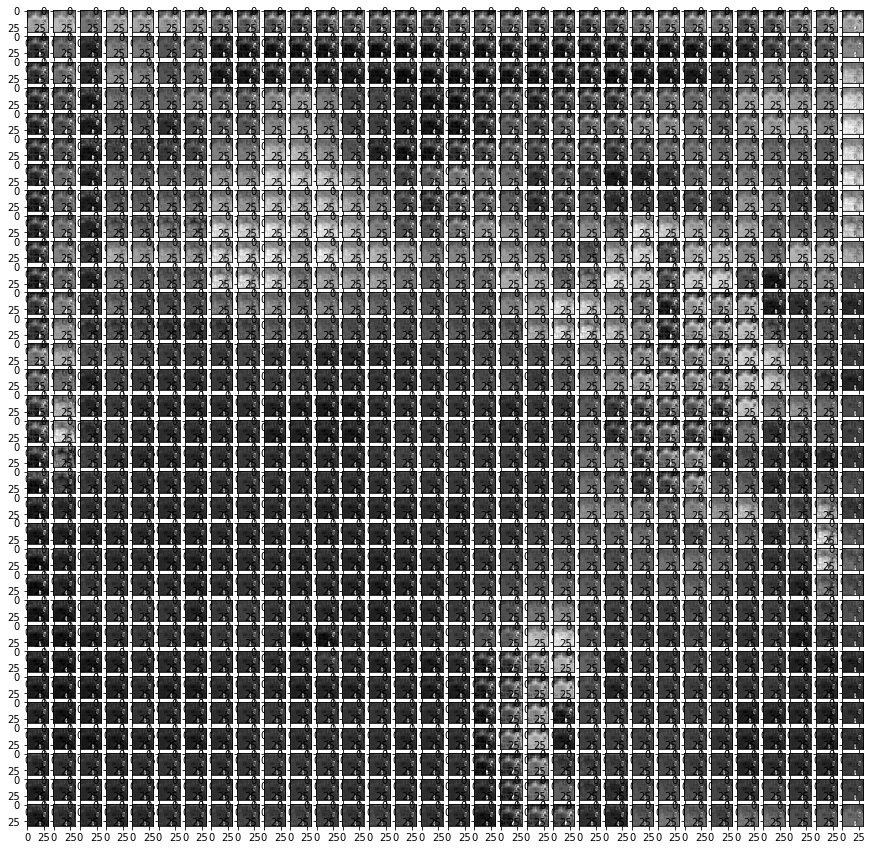

In [35]:
plt.figure(figsize=(15, 15))
act_tens = genval_attn
for idx in range(0,32):
    for idy in range(0,32):
        plt.subplot(32, 32, idy + idx*32 + 1)
        plt.imshow(act_tens[idx,idy,:,:], cmap = 'gray')
plt.show()

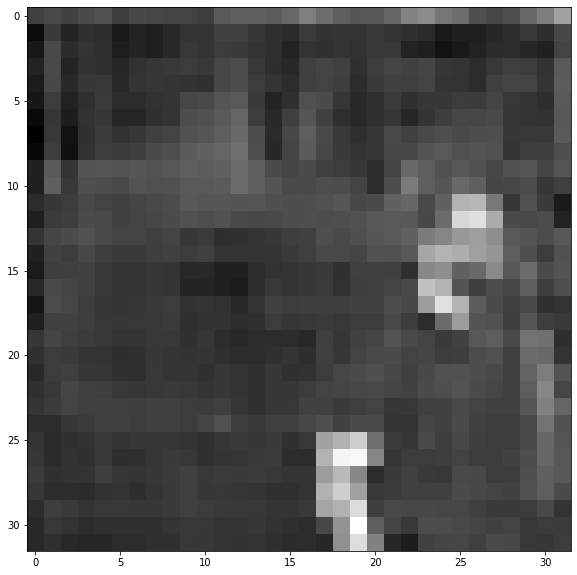

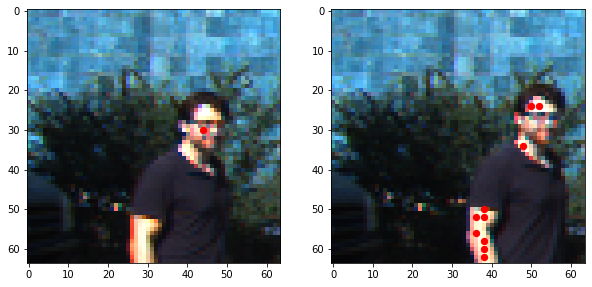

In [36]:
orig_x = 30
orig_y = 44
plt.figure(figsize=(10, 10))
plt.imshow(genval_attn[orig_x // 2, orig_y // 2, :, :], cmap = 'gray')
plt.show()

top_attn = genval_attn[orig_x // 2, orig_y // 2, :, :]
idx = np.argsort(top_attn,axis = None)[-10:]
midx = np.unravel_index(idx, top_attn.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(insamp[3])
plt.scatter(orig_y, orig_x, color='red', s=40)
plt.subplot(1,2,2)
plt.imshow(outsamp)
plt.scatter([x*2 for x in midx[1]], [x*2 for x in midx[0]], color='red', s=40)
plt.show()